In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# by hand, runs faster
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

# pythonic alternative (however: slower) to do the same thing:
def compute_return_2(df, r_type="log", h=1):
    
    if r_type == "log":
        return (np.log(df) - np.log(df.shift(h))) * 100
    else:
        return ((df-df.shift(h))/df) * 100 

In [24]:
import yfinance as yf

dax = yf.Ticker("^GDAXI")

hist = dax.history(period="max")

for i in range(5):
    hist["ret"+str(i+1)] = compute_return(hist["Close"].values, h=i+1)

In [25]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5
Date,,,,,,,,,,,,
2023-11-02 00:00:00+01:00,15033.650391,15202.429688,15028.030273,15143.599609,89446500,0.0,0.0,1.465627,2.225240,2.860594,3.058730,2.762048
2023-11-03 00:00:00+01:00,15203.799805,15269.500000,15149.719727,15189.250000,93603800,0.0,0.0,0.300997,1.766623,2.526237,3.161591,3.359727
2023-11-06 00:00:00+01:00,15219.320312,15223.410156,15110.839844,15135.969727,59212500,0.0,0.0,-0.351393,-0.050396,1.415230,2.174844,2.810198
2023-11-07 00:00:00+01:00,15084.790039,15194.530273,15068.250000,15152.639648,62049600,0.0,0.0,0.110074,-0.241319,0.059678,1.525304,2.284918
2023-11-08 00:00:00+01:00,15093.480469,15287.730469,15086.410156,15229.599609,0,0.0,0.0,0.506613,0.616686,0.265294,0.566290,2.031917


In [7]:
# quantile levels
tau = [.025, .25, .5, .75, .975]

In [8]:
# define prediction array
# cols are quantile levels, rows are horizons

pred_baseline = np.zeros((5,5))

In [20]:
last_t = 100

for i in range(5):
    
    ret_str = "ret"+str(i+1)
    pred_baseline[i,:] = np.quantile(hist[ret_str].iloc[-last_t:], q=tau)

Visualize the results

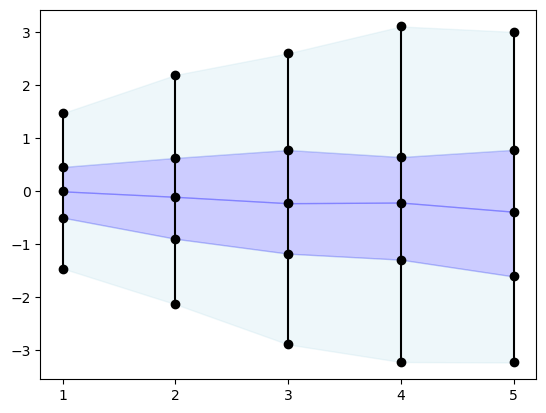

In [22]:
x = np.arange(5)+1
quantiles = tau
# tau = [.025, .25, .5, .75, .975]

colors = ['lightblue', 'blue', 'blue', 'lightblue']

# Creating colored intervals between quantiles
for i in range(len(quantiles) - 1):
    plt.fill_between(
        x,
        pred_baseline[:, i],
        pred_baseline[:, i + 1],
        alpha=0.2,  # Adjust transparency as needed
        color=colors[i],
        label=f'Quantile {quantiles[i]} - {quantiles[i + 1]}'
    )
    
_ = plt.plot(x, pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

Create Submission DataFrame

In [31]:
from datetime import datetime
date_str = datetime.today().strftime('%Y-%m-%d')

In [32]:
df_sub = pd.DataFrame({
    
    "forecast_date": date_str, 
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1,2,5,6,7)],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]

})

df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-08,DAX,1 day,-1.466625,-0.507206,-0.010599,0.448124,1.464229
1,2023-11-08,DAX,2 day,-2.140536,-0.905687,-0.114126,0.619247,2.184070
2,2023-11-08,DAX,5 day,-2.898839,-1.186168,-0.234773,0.768097,2.593119
3,2023-11-08,DAX,6 day,-3.230156,-1.299488,-0.222153,0.635851,3.098539
4,2023-11-08,DAX,7 day,-3.239166,-1.616450,-0.395428,0.771561,2.996221


In [62]:
for row_to_check in range(df_sub.shape[0]):
    row_values = df_sub.iloc[row_to_check, 3:].values
    is_ordered = all(row_values[i] <= row_values[i + 1] for i in range(len(row_values) - 1))
    print(is_ordered)

True
True
True
True
True


In [63]:
#need to change this
PATH = "/Users/yanting/OneDrive/Desktop/23_24 WS (Master)/PTSFC/Submissions"

date_str = datetime.today().strftime('%Y_%m_%d')

df_sub.to_csv(PATH+"/"+date_str+"_DAX_benchmark.csv",index=False)

5